In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
# 多行输出
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 

# NMF and SVD

![NMF and SVD](../imgs/NMF1.png)

- 传统的奇异值分解方法只能对稠密矩阵进行分解，即不允许所分解矩阵有空值。因而，若采用奇异值分解，需要首先填充数值，这样造成了两个问题：
    - 其一，填充大大增加了数据量，增加了算法复杂度
    - 其二，简单粗暴的数据填充很容易造成数据失真

- 使用矩阵分解具有以下优点：
    - 比较容易编程实现，随机梯度下降方法依次迭代即可训练出模型
    - 比较低的时间和空间复杂度，高维矩阵映射为两个低维矩阵节省了存储空间，训练过程比较费时，但是可以离线完成
    - 评分预测一般在线计算，直接使用离线训练得到的参数，可以实时推荐
    - 预测的精度比较高，预测准确率要高于基于领域的协同过滤以及内容过滤等方法
    - 非常好的扩展性，很方便在用户特征向量和物品特征向量中添加其它因素

- 矩阵分解的不足主要有：
    - 模型训练比较费时。
    - 推荐结果不具有很好的可解释性，分解出来的用户和物品矩阵的每个维度无法和现实生活中的概念来解释，无法用现实概念给每个维度命名，只能理解为潜在语义空间。

- 非负矩阵分解(non-negative matrix factorization)1，或非负矩阵近似(non-negative matrix approximation)，是多变量分析和线性代数的算法。
    - 输入：非负矩阵V
    - 输出：两个非负矩阵W和H
    - 目标：V=WH
- 优点
    - 处理大规模数据更快更便捷；
    - 实现简便性、分解形式和分解结果上的可解释性，占用存储空间少。
- 缺点
    - NMF中只用一层表示隐变量，无法处理复杂学习问题；
    - NMF只约束了W和H的非负性（这是唯一先验，只要求满足这个），而没有考虑到对于该先验，H内部元素间的相关性。
- 应用领域
　　- 计算机视觉，文档聚类，化学统计学，音频信号处理，推荐系统

![NMF and SVD](../imgs/NMF2.png)
![NMF and SVD](../imgs/NMF3.png)

In [3]:
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn import decomposition
from scipy import linalg
import matplotlib.pyplot as plt

## 数据集
newsgroups数据集包含20个话题的18000篇新闻。

In [4]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
remove = ('headers', 'footers', 'quotes')
# 只下载 上述的4个话题数据并删除 'headers', 'footers', 'quotes'
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories, remove=remove)
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories, remove=remove)

In [6]:
# 把文件名理解为 x 话题理解为 y
newsgroups_train.filenames.shape, newsgroups_train.target.shape

((2034,), (2034,))

In [13]:
# 查看数据信息
len(newsgroups_train.data[:3])
print('\n'.join(newsgroups_train.data[:3]))

3

Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych


Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes like Koresh have been demonstrating such evil corruption
for centuries.

 >In article <1993Apr19.020359.26996@sq.sq.com>, msb@sq.sq.c

In [20]:
newsgroups_train.target_names  # 数据集的类别
newsgroups_train.filenames[:5] # 前三个样本的x和y
newsgroups_train.target[:5] # 类别是类名的索引

['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']

array(['/home/lab/scikit_learn_data/20news_home/20news-bydate-train/comp.graphics/38816',
       '/home/lab/scikit_learn_data/20news_home/20news-bydate-train/talk.religion.misc/83741',
       '/home/lab/scikit_learn_data/20news_home/20news-bydate-train/sci.space/61092',
       '/home/lab/scikit_learn_data/20news_home/20news-bydate-train/alt.atheism/51306',
       '/home/lab/scikit_learn_data/20news_home/20news-bydate-train/sci.space/60903'],
      dtype='<U90')

array([1, 3, 2, 0, 2])

## 生成词典

In [22]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [30]:
vectorizer = CountVectorizer(stop_words='english') # sparse matrix
vectors = vectorizer.fit_transform(newsgroups_train.data).todense() # (documents, vocab)
vectors  # 词汇统计
vectors.shape #, vectors.nnz / vectors.shape[0], row_means.shape
# 总共出现了 26576 个词汇，一共有2034个训练样本

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

(2034, 26576)

In [39]:
# 查看词汇
vocab = np.array(vectorizer.get_feature_names())
vocab.shape
vocab[10000:10100]

(26576,)

array(['factors', 'factory', 'facts', 'factsnet', 'factual', 'factually',
       'faculty', 'fade', 'fades', 'fading', 'fag', 'faget', 'faggots',
       'fahrenheit', 'fai', 'fail', 'failed', 'failing', 'fails',
       'failsafe', 'failure', 'failures', 'faily', 'fain', 'faint',
       'fainter', 'fair', 'fairchild', 'fairfield', 'fairgrove',
       'fairing', 'fairly', 'fairness', 'fairy', 'fait', 'faith',
       'faithful', 'faithfully', 'faiths', 'fake', 'faking', 'falguiere',
       'falkow', 'fall', 'fallacies', 'fallacious', 'fallaciously',
       'fallacy', 'fallacys', 'fallback', 'fallen', 'fallible', 'falling',
       'falls', 'false', 'falsehood', 'falsely', 'falseness',
       'falsifiable', 'falsification', 'falsified', 'falsify',
       'faltering', 'fama', 'fame', 'familar', 'familia', 'familial',
       'familiar', 'familiarity', 'familiarize', 'familiarized',
       'families', 'familiy', 'family', 'famine', 'famous', 'fan',
       'fanatic', 'fanatical', 'fanatically',

## SVD 解决方案

SVD算法将一个矩阵分解为一个正交列矩阵和一个正交行矩阵
![SVD](../imgs/svd_fb.png)

In [42]:
%%time
U, s, Vh = linalg.svd(vectors, full_matrices=False) # 这里full_matrices=False保证，我们得到的是 (M, K) 和 (K, N)

CPU times: user 4min 3s, sys: 22.5 s, total: 4min 25s
Wall time: 22.9 s


In [45]:
# 上述运行太慢
print(U.shape, s.shape, Vh.shape)

(2034, 2034) (2034,) (2034, 26576)


In [46]:
U, s, Vh

(array([[-4.77990794e-03,  2.71987875e-03, -1.21235561e-03, ...,
         -1.13097805e-17, -2.38876142e-18,  7.89898457e-17],
        [-2.21299669e-04, -1.74990511e-04, -1.07815079e-03, ...,
         -1.33032527e-16,  8.13436485e-17,  4.77231346e-16],
        [-6.36934010e-04, -7.42290500e-04, -8.31832870e-04, ...,
         -2.20260011e-16, -7.30012664e-17, -4.20336566e-16],
        ...,
        [-1.38527330e-03, -7.35183579e-04, -2.33163116e-04, ...,
          1.21268013e-16, -4.88975180e-17, -7.41594286e-17],
        [-2.17182920e-03,  6.80947315e-04, -9.56544786e-03, ...,
          2.79182059e-17, -7.76830857e-17,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]]),
 array([4.33926985e+02, 2.91510127e+02, 2.40711377e+02, ...,
        1.95236382e-15, 1.83950100e-15, 1.10014025e-15]),
 array([[-9.40971949e-03, -1.14531979e-02, -2.16949925e-05, ...,
         -5.71798766e-06, -1.14359753e-05, -1

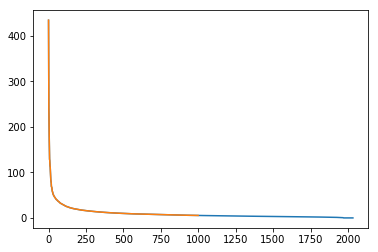

In [51]:
# 奇异值
plt.plot(s)

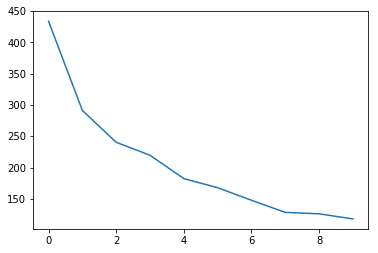

In [56]:
plt.plot(s[:10])

In [57]:
num_top_words=8  # 从图像可以看到，刚开始奇异值较大但是在后面的部分奇异值趋于平缓，
# 所以，我们选取前8个作为最重要的特征

In [74]:
def show_topics(a):
#      排序获取索引，升序， num_top_words 个
    top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_top_words-1:-1]]
    topic_words = [top_words(t) for t in a]
    return [' '.join(t) for t in topic_words]

In [75]:
Vh[5]

array([-2.33486321e-04, -1.32619828e-02, -7.09455676e-06, ...,
       -1.38971753e-05, -2.77943506e-05, -2.45664960e-05])

In [87]:
show_topics(Vh[:10])
newsgroups_train.target_names
c = newsgroups_train.target[:10]
[newsgroups_train.target_names[i] for i in c]

['ditto critus propagandist surname galacticentric kindergarten surreal imaginative',
 'jpeg gif file color quality image jfif format',
 'graphics edu pub mail 128 3d ray ftp',
 'jesus god matthew people atheists atheism does graphics',
 'image data processing analysis software available tools display',
 'god atheists atheism religious believe religion argument true',
 'space nasa lunar mars probe moon missions probes',
 'image probe surface lunar mars probes moon orbit',
 'argument fallacy conclusion example true ad argumentum premises',
 'space larson image theory universe physical nasa material']

['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']

['comp.graphics',
 'talk.religion.misc',
 'sci.space',
 'alt.atheism',
 'sci.space',
 'alt.atheism',
 'sci.space',
 'comp.graphics',
 'sci.space',
 'comp.graphics']

## NMF 方法

- NMF是限制元素是非负的，SVD是限制矩阵是正交的
- 正值更容易解释
- 非精确分解
- $V=WH$

In [80]:
m, n = vectors.shape
m, n
d=5  # num topics

(2034, 26576)

In [85]:
clf = decomposition.NMF(n_components=d, random_state=1)
W1 = clf.fit_transform(vectors)
H1 = clf.components_
W1.shape, H1.shape

((2034, 5), (5, 26576))

In [79]:
show_topics(H1)

['jpeg image gif file color images format quality',
 'edu graphics pub mail 128 ray ftp send',
 'space launch satellite nasa commercial satellites year market',
 'jesus god people matthew atheists does atheism said',
 'image data available software processing ftp edu analysis']

## 使用 SGD 学习NMF

损失函数看做 MSE 的回归问题

In [88]:
# 非负分解,当元素 < 0 时,惩罚
def penalty(A):
    return torch.pow((A<0) * torch.clamp(A, max=0.), 2)

def penalize():
    return penalty(pW).mean() + penalty(pH).mean()

def loss():
    return (M-pW.mm(pH)).norm(2) + penalize()*lam

* NMF 计算快的原因是,其只计算关心的那些列,(原来是26576列,现在只保留5列)而SVD要全部计算,可以通过截断SVD来实现.(选取奇异值最大的几列)
- 计算完整的SVD非常缓慢
- 随机SVD只计算我们需要的列.比如我们计算的是 (2034,5),(5,)(5,26576)

## LU 分解

在线性代数与数值分析中，LU分解是矩阵分解的一种，将一个矩阵分解为一个下三角矩阵和一个上三角矩阵的乘积，有时需要再乘上一个置换矩阵。LU分解可以被视为高斯消元法的矩阵形式。在数值计算上，LU分解经常被用来解线性方程组、且在求反矩阵和计算行列式中都是一个关键的步骤

[LU分解](https://zh.wikipedia.org/wiki/LU%E5%88%86%E8%A7%A3)

In [89]:
help(linalg.lu)

Help on function lu in module scipy.linalg.decomp_lu:

lu(a, permute_l=False, overwrite_a=False, check_finite=True)
    Compute pivoted LU decomposition of a matrix.
    
    The decomposition is::
    
        A = P L U
    
    where P is a permutation matrix, L lower triangular with unit
    diagonal elements, and U upper triangular.
    
    Parameters
    ----------
    a : (M, N) array_like
        Array to decompose
    permute_l : bool, optional
        Perform the multiplication P*L  (Default: do not permute)
    overwrite_a : bool, optional
        Whether to overwrite data in a (may improve performance)
    check_finite : bool, optional
        Whether to check that the input matrix contains only finite numbers.
        Disabling may give a performance gain, but may result in problems
        (crashes, non-termination) if the inputs do contain infinities or NaNs.
    
    Returns
    -------
    **(If permute_l == False)**
    
    p : (M, M) ndarray
        Permutation matr

In [90]:
A = np.array([[2, 5, 8, 7], [5, 2, 2, 8], [7, 5, 6, 6], [5, 4, 4, 8]])

In [93]:
pl, u = linalg.lu(A, permute_l=True)

In [94]:
np.allclose(A - pl @ u, np.zeros((4, 4)))

True

## QR 分解

QR分解法是三种将矩阵分解的方式之一。这种方式，把矩阵分解成一个半正交矩阵与一个上三角矩阵的积。QR分解经常用来解线性最小二乘法问题。QR分解也是特定特征值算法即QR算法的基础

[QR分解](https://zh.wikipedia.org/wiki/QR%E5%88%86%E8%A7%A3)